# 🧠 Stroke Prediction – Data Mining Project

This notebook analyzes the likelihood of stroke occurrence based on health and demographic features using various machine learning methods.

## 1. Dataset Overview

- **Source**: [Kaggle – Stroke Prediction Dataset](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset)
- **Total records**: 5110
- **Target column**: `stroke` (0 = no stroke, 1 = stroke)
- Features include: age, gender, hypertension, heart_disease, bmi, glucose, smoking_status, etc.


## 2. Initial Exploration

We begin by loading the dataset and exploring the basic structure and distributions.

- The dataset contains 5,110 records.
- The target variable `stroke` is highly imbalanced (~5% positive cases).
- There are missing values in the `bmi` column.
- We visualize the age distribution and observe that stroke cases increase with age.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


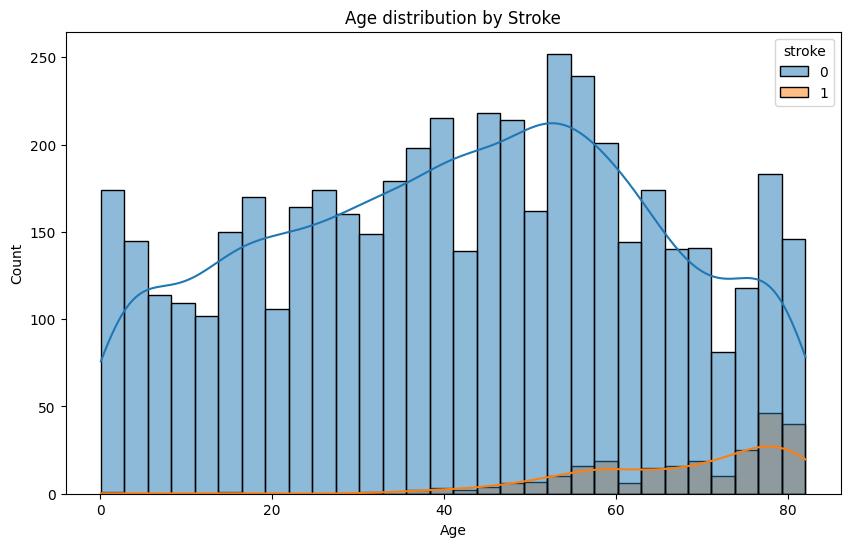

In [5]:
import pandas as pd

# טוען את הקובץ שהעלית
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

# מציג את 5 השורות הראשונות
df.head()
# הצגת מידע כללי על הנתונים
df.info()

# בדיקת כמות ערכים חסרים
df.isnull().sum()

# הצגת התפלגות לפי מחלקת המטרה
df['stroke'].value_counts(normalize=True)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='age', hue='stroke', bins=30, kde=True)
plt.title('Age distribution by Stroke')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()


## 3. Data Preprocessing

- Removed the `id` column, which carries no predictive value.
- Removed rare gender label `Other` (only one occurrence).
- Imputed missing values in the `bmi` column using the mean.
- Encoded categorical variables (gender, work_type, smoking_status, etc.) using `LabelEncoder`.

In [6]:
# שלב 1 – הסרת עמודת id
df = df.drop(columns=['id'])

# שלב 2 – הסרת רשומות נדירות (gender = 'Other')
df = df[df['gender'] != 'Other']

# שלב 3 – השלמת ערכי BMI חסרים עם ממוצע
df['bmi'] = df['bmi'].fillna(df['bmi'].mean())

In [7]:
from sklearn.preprocessing import LabelEncoder

# עותק של המסגרת המקורית
df_encoded = df.copy()

# ממירים כל עמודה לא מספרית לערכים מספריים
for col in df_encoded.select_dtypes(include='object').columns:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])


## 4. Class Imbalance Handling

- The dataset is highly imbalanced: ~5% of the patients experienced a stroke.
- Used **SMOTE (Synthetic Minority Oversampling Technique)** to create synthetic examples of the minority class (`stroke=1`).
- After SMOTE, the classes are balanced and ready for model training.

In [8]:
from imblearn.over_sampling import SMOTE

X = df_encoded.drop('stroke', axis=1)
y = df_encoded['stroke']

# איזון עם SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# בדיקה – כמה דגימות יש עכשיו מכל מחלקה
pd.Series(y_resampled).value_counts()


,count
stroke,
1,4860
0,4860


## 5. Decision Tree Classifier

We trained a Decision Tree model using the resampled dataset (after SMOTE).

- Split the dataset into training (70%) and testing (30%) sets
- Used Gini impurity as the split criterion
- Set maximum depth to 5 to prevent overfitting
- Evaluated the model using classification report and confusion matrix

The tree achieved high accuracy and recall for stroke cases, making it suitable for medical screening.

              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1458
           1       0.77      0.92      0.84      1458

    accuracy                           0.83      2916
   macro avg       0.84      0.83      0.82      2916
weighted avg       0.84      0.83      0.82      2916



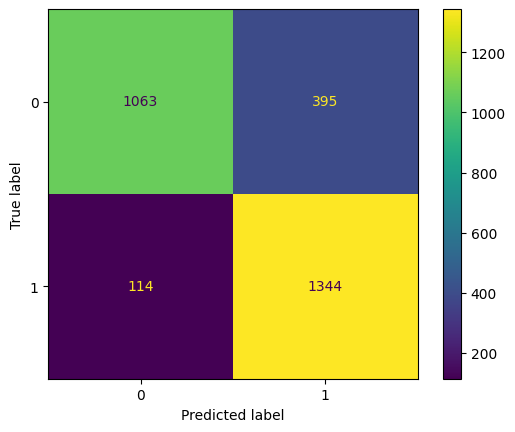

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# חלוקה ל־train ו־test
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# בניית עץ החלטה
clf = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=42)
clf.fit(X_train, y_train)

# תחזית
y_pred = clf.predict(X_test)

# תצוגה
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)


### 📊 Visualizing the Decision Tree

Below is the structure of the trained decision tree:

- The root node splits on the most informative feature.
- Each branch represents a decision rule.
- Leaves represent predicted classes (No Stroke / Stroke).
- Color intensity indicates confidence in prediction.

This visualization helps interpret the model and understand which features contribute most to stroke prediction.

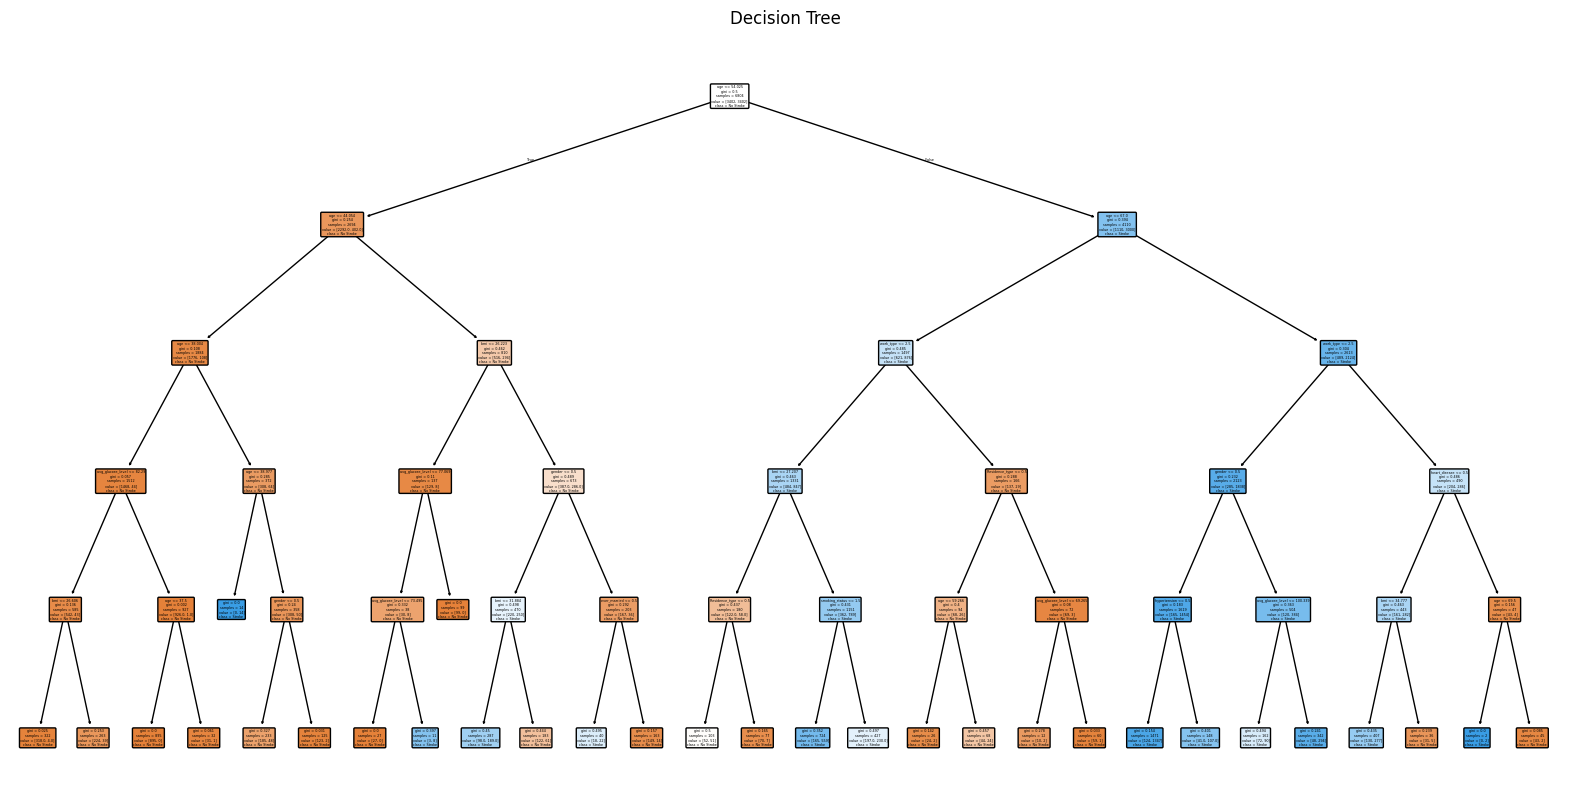

In [10]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(clf, feature_names=X.columns, class_names=['No Stroke', 'Stroke'], filled=True, rounded=True)
plt.title("Decision Tree")
plt.show()


## 6. Clustering – KMeans

We applied **KMeans clustering** to discover underlying patterns in the population based on medical features.

- Selected only relevant medical attributes: `age`, `hypertension`, `heart_disease`, `glucose`, `bmi`, `smoking_status`
- Normalized the data using `StandardScaler`
- Ran KMeans with **k=2** to form two clusters

### 🧠 Results:

- **Cluster 0** had a higher proportion of stroke cases (~7.8%)
- **Cluster 1** contained mostly healthy individuals
- Confirms that clustering based on risk factors reflects real-world stroke risk

In [11]:
kmeans_df = df_encoded.copy()

# נשמור רק תכונות רפואיות ורלוונטיות
kmeans_df = kmeans_df[['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']]


In [12]:
from sklearn.preprocessing import StandardScaler

features = kmeans_df.drop('stroke', axis=1)
target = kmeans_df['stroke']

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


In [13]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(features_scaled)


In [14]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# הוספת עמודת אשכולות
kmeans_df['cluster'] = clusters

# התפלגות stroke לפי אשכול
pd.crosstab(kmeans_df['cluster'], kmeans_df['stroke'], margins=True)


stroke,0,1,All
cluster,,,
0,2722,229,2951
1,2138,20,2158
All,4860,249,5109


### 📈 Visualizing Clusters (Age vs. BMI)

The following scatter plot shows how patients are grouped by KMeans:

- **X-axis**: Age  
- **Y-axis**: BMI  
- **Color**: Cluster (0 or 1)  
- **Shape**: Stroke status

We observe that one cluster (typically Cluster 0) contains a higher concentration of stroke cases and includes older patients with highe

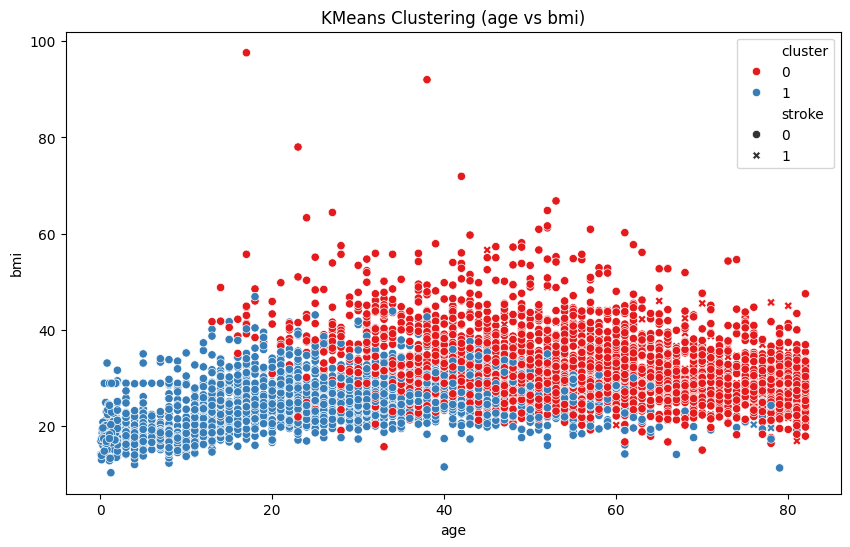

In [15]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=kmeans_df, x='age', y='bmi', hue='cluster', style='stroke', palette='Set1')
plt.title('KMeans Clustering (age vs bmi)')
plt.show()


## 7. Neural Network (Keras MLP)

We built a Multilayer Perceptron (MLP) using **Keras** to classify stroke risk.

### 🔧 Architecture:
- Input: all normalized features
- Hidden layers: 16 → 8 neurons with ReLU activation
- Output layer: 1 neuron with Sigmoid (for binary classification)
- Optimizer: Adam
- Loss function: Binary Crossentropy
- Epochs: 50, Batch size: 32

### ⚙️ Preprocessing:
- Applied `StandardScaler` normalization
- Applied **SMOTE** only to the training set to avoid data leakage

### 📉 Training Results:
- The loss graph shows a stable decrease over time
- No strong signs of overfitting

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# משתנים
X = df_encoded.drop('stroke', axis=1)
y = df_encoded['stroke']

# חלוקה
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# נירמול
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SMOTE רק על סט האימון!
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)


In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# בניית המודל
model = keras.Sequential([
    layers.Input(shape=(X_train_smote.shape[1],)),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# קומפילציה
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# אימון
history = model.fit(X_train_smote, y_train_smote, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test))


Epoch 1/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5328 - loss: 0.7091 - val_accuracy: 0.6993 - val_loss: 0.5235
Epoch 2/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7929 - loss: 0.4930 - val_accuracy: 0.7358 - val_loss: 0.4870
Epoch 3/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8139 - loss: 0.4271 - val_accuracy: 0.7560 - val_loss: 0.4635
Epoch 4/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8176 - loss: 0.4100 - val_accuracy: 0.7593 - val_loss: 0.4536
Epoch 5/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8242 - loss: 0.3954 - val_accuracy: 0.7534 - val_loss: 0.4623
Epoch 6/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8191 - loss: 0.3917 - val_accuracy: 0.7763 - val_loss: 0.4137
Epoch 7/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8353 - loss: 0.3776 - val_accuracy: 0.7639 - val_loss: 0.4398
Epoch 8/50
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8307 - loss: 0.3762 - val_accuracy: 0.

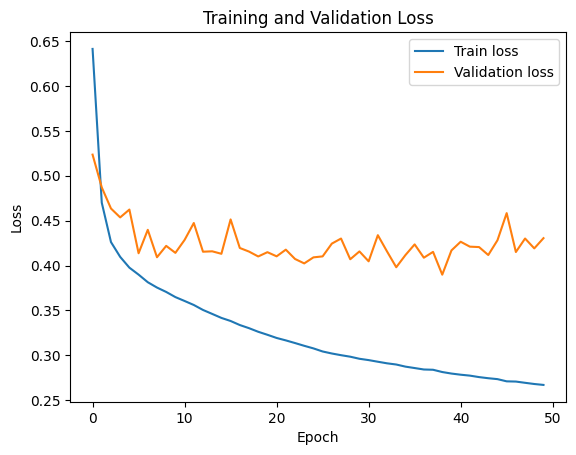

In [18]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
              precision    recall  f1-score   support

           0       0.96      0.83      0.89      1444
           1       0.14      0.47      0.22        89

    accuracy                           0.81      1533
   macro avg       0.55      0.65      0.56      1533
weighted avg       0.91      0.81      0.85      1533



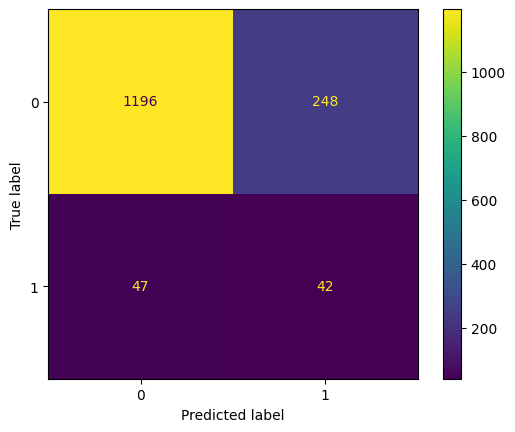

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# תחזית
y_pred_probs = model.predict(X_test_scaled)
y_pred = (y_pred_probs > 0.5).astype(int)

# תוצאות
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)


### 📊 Model Evaluation

After training, we evaluated the neural network's performance on the test set.

- The model achieved an accuracy of ~81%
- **Recall for stroke cases**: 47%
- **Precision for stroke**: only 14%, indicating many false positives
- Confusion matrix shows the model tends to classify many patients as "at risk" to avoid missing actual stroke cases

This is typical for imbalanced medical datasets — models prioritize **recall** (catching positive cases), even at the cost of **precision**.